<a href="https://colab.research.google.com/github/EarlJr53/mbta-cr-classification/blob/main/MBTA_CR_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MBTA Commuter Rail Ridership Classification
**Brooke Moss - Olin College Machine Learning FA24**

[MBTA Data Source](https://mbta-massdot.opendata.arcgis.com/datasets/3b93de20570f462ea27219dfb7e75347_0/explore) ----- [Project GitHub Repository](https://github.com/EarlJr53/mbta-cr-classification)


---



## Background

For this mini-project, I decided to explore data published by the Massachusetts Bay Transportation Authority (MBTA) containing ridership statistics of their Commuter Rail trains. This dataset contains average ridership data from Spring 2012 and Spring 2018, separated by train ID number and by stop. This data includes embarkments, disembarkments, and train load for each stop.

### Why?

To be quite honest, this model has very little practical purpose, if any. For the most part, I chose this project because I wanted to do something with MBTA Commuter Rail data and this is the data that was available to me conveniently, with categorical variables that could work well for a classification assignment. Also, as people at Olin tend to have figured out by now, I like trains. Just a little bit.

In all seriousness, this model itself is not very useful, but models based on similar data could be very useful for train operations. This is especially true of models based on realtime, more granular data, rather than the averaged data that I have access to. For instance, using daily data for environmental variables (like time of day, train direction, etc.) could help predict ridership for different trains throughout the day and throughout the year. That is not a classification project, but predicting ridership based on external variables could allow Keolis (the MBTA Commuter Rail operator) to assign rolling stock capacity to the correct routes and trains throughout the day, ensuring that public seat demand is met. This could also potentially allow Keolis and the MBTA to set schedules and determine when equipment can safely be taken out of revenue service for repairs and regular servicing.

### Who?

For this model specifically, I think the only truly relevant stakeholder is me. However, a model made using similar data, as described above, includes Keolis, the MBTA, MassDOT, and the transit-riding public as important stakeholders.

### How?

To evaluate this model, I decided to visualize the prediction accuracy and plot a confusion matrix of the predictions for each route so that I could understand what underlying relationships and traits of each line may have influenced the predictions. I don't believe this model is really worthy of very rigorous evaluation, but I was aiming for high accuracy as my primary metric.


---



## Setup

### Imports & Environment

Before going further, we need to ensure we have all the necessary dependencies installed. We can also check whether this notebook is running in a Google Colab environment or locally, informing how we will decide to import our dataset. We also check whether there is a GPU available or whether we should run our models on the CPU.

In [ ]:
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import os

# Check if running in Colab environment
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# see if we can run on the GPU (change your runtime to T4 if you want cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load Dataset

To ease the data loading workflow, I have downloaded the dataset as a CSV and placed it [in the same git repo](https://github.com/EarlJr53/mbta-cr-classification) as this notebook. If this notebook is running in Colab, we need to download the dataset from the repo, otherwise we can just assume it exists in the local directory and load it directly. Here, we are just loading the dataset as-is into a Pandas DataFrame.

In [ ]:
# The CSV is stored in my git repo to make access easier and not burden the MBTA portal
csv_name = './MBTA_Commuter_Rail_Ridership.csv'
csv_url = "https://raw.githubusercontent.com/EarlJr53/mbta-cr-classification/refs/heads/main/MBTA_Commuter_Rail_Ridership.csv"

# If in Colab environment, download dataset to Colab's local directory
# Otherwise, assume running locally from git repo where data is already present
if IN_COLAB:
    response = requests.get(csv_url, stream=True)
    if response.status_code == 200:
        with open(csv_name, "wb") as f:
            f.write(response.content)
        f.close()
        if os.path.exists(csv_name):
            print("File downloaded successfully!")
    else:
        print(f"Error downloading file: {response.status_code}")
        exit()

# Load dataset from CSV
df_ridership_raw = pd.read_csv(csv_name)

File downloaded successfully!


### Understanding the Dataset

Relevant features of this dataset:
- `route_id`: The Commuter Rail route/line this train is running on. This is what we will be predicting.
- `train`: The service number of this train (i.e. Train 744 runs on the Fairmount Line, inbound toward Boston, around midday). This is what we will be grouping the data by.
- `direction_id`: Binary value representing whether the train is travelling inbound toward Boston (1) or outbound away from Boston (0). This is one of the values we experiment with using as a prediction feature.
- `stopsequence`: The index of a stop along a given train's route. This will be used to pivot our data.
- `average_ons`: Average boardings of the given `train` at the given `stop_id` over the study period.
- `average_offs`: Average disembarkments of the given `train` at the given `stop_id` over the study period.
- `average_load`: Average passenger load of the given `train` at the given `stop_id` over the study period.

In [ ]:
df_ridership_raw.head()

,season,route_id,route_name,train,direction_id,day_type_id,day_type_name,stop_time,stop_id,stopsequence,average_ons,average_offs,average_load,ObjectId
0,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:35:00+00,Readville,4,11.0,NaN,11.0,1
1,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:38:00+00,Fairmount,5,19.0,0.0,30.0,2
2,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:42:00+00,Morton Street,6,8.0,0.0,38.0,3
3,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 11:49:00+00,Uphams Corner,7,7.0,1.0,44.0,4
4,Spring 2012,CR-Fairmount,Fairmount Line,744,1,day_type_01,weekday,2018/01/01 12:02:00+00,South Station,8,NaN,44.0,NaN,5


### Pivoting the Data

The features we want to include in our predictions are `direction_id`, `average_load`, `average_ons`, and `average_offs`, while predicting `route_id`. The goal is for each `train` to have associated data for load, boardings, and disembarkments for each stop along its route. To do this, we pivot the data so that each `train` has its own data row with each of the aforementioned features for each of the 19 maximum possible stops.

In [ ]:
df_ridership = df_ridership_raw.pivot_table(index=['train', 'route_id', 'direction_id'], columns='stopsequence', values=['average_ons', 'average_offs', 'average_load'], fill_value=0).reset_index()
df_ridership.head()

train          route_id direction_id average_load                \
stopsequence                                                 1      2      3   
0               10  CR-Middleborough            1        114.0  179.5  212.0   
1              100    CR-Newburyport            1         10.0   19.0   21.0   
2              101    CR-Newburyport            0         15.0   10.0   10.0   
3              102    CR-Newburyport            1         14.0   34.5   35.5   
4              103    CR-Newburyport            0         39.0   38.0   37.0   

                                          ... average_ons                  \
stopsequence      4      5      6      7  ...          10   11   12    13   
0             264.0  312.5  355.5  347.5  ...         0.0  0.0  0.0   0.0   
1              29.0   40.0    0.0   49.0  ...         0.0  0.0  0.0  62.0   
2               0.0    0.0   13.0   10.0  ...         0.0  0.0  0.0   1.0   
3              56.5   62.5   69.0   80.0  ...         0.0  0.0  0.0  49.0   
4              43.0   47.5   32.0   18.5  ...         0.0  0.0  0.0   0.5   

                                                
stopsequence    14    15    16   17    18   19  
0              0.0   0.0   0.0  0.0   0.0  0.0  
1             76.0  43.0  17.0  0.0   2.0  0.0  
2              0.0   0.0   0.0  0.0   1.0  0.0  
3             92.5  81.0  23.5  0.0  11.5  0.0  
4              0.0   0.5   0.5  0.5   0.5  0.0  

[5 rows x 60 columns]

## The Model

### Previous Ideas

Now is a good time to mention some of the ideas that were considered to make these predictions and how the current set of features was decided upon. I considered utilizing the `stop_time` feature to help make my predictions, but decided against this when I realized that predicting solely based on ridership would be a more exciting problem to solve.



### Creating the Base Model

Here we create a simple multi-level perceptron model with 1 hidden layer, utilizing the sigmoid function.

We also define a few values that will be shared across our models, including the learning rate, cross-entropy loss function, and number of steps.

In [ ]:
class MLP(nn.Module):
    """ A simple MLP classifier model for classifying MBTA trains. """
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # initialize the model weights
        self.linear_1 = nn.Linear(input_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.linear_1(x)
        out = F.sigmoid(out)
        out = self.linear_2(out)
        return out

# Some values that are shared between the models
# Neither of these values were tuned extensively as part of the model tuning
n_epochs = 1000
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()

### Defining the Inputs and Outputs

Here we have defined 3 distinct sets of inputs for our models:
- One with train direction as well as boardings, disembarkments, and load for all stations
- A second with boardings, disembarkments, and load for all stations, but without the train direction
- A third with only train load for all stations and none of the other features

We have also defined the outputs to the `route_id` contents, the unique values of which can be seen printed below.

In [ ]:
inputs_all = df_ridership[['average_offs', 'average_ons', 'average_load', 'direction_id']]
inputs_wo_dir = df_ridership[['average_offs', 'average_ons', 'average_load']]
inputs_load = df_ridership[['average_load']]

outputs_1, unique = df_ridership['route_id'].factorize()
print(f"List of unique route IDs: {', '.join(unique.tolist())}")

List of unique route IDs: CR-Middleborough, CR-Newburyport, CR-Haverhill, CR-Lowell, CR-Kingston, CR-Fitchburg, CR-Worcester, CR-Needham, CR-Greenbush, CR-Franklin, CR-Fairmount, CR-Providence


### Model without Direction

Once I had latched onto the idea of pivoting the data and predicting the route based on just the ridership characteristics (rather than including external factors like time of day), I settled on this model. This model includes all of the boardings, disembarkments, and load, but not the train direction, as this was something that was added later.

In this block of code, we split the training and test data, create the model with 60 nodes in the single hidden layer, and run the model on our training and test data.

In [ ]:
# each input is 57 features (3 data types and 19 stops)
# the output has 12 options because there are 12 rail lines

model_wo_dir = MLP(57, 60, 12).to(device)

X_train_wo_dir, X_test_wo_dir, y_train_wo_dir, y_test_wo_dir = train_test_split(
                                                    inputs_wo_dir,
                                                    outputs_1,
                                                    test_size=0.3,
                                                    random_state=42)


# convert from numpy to pytorch and also move the data to the GPU
X_train_wo_dir = torch.from_numpy(X_train_wo_dir.values.astype(np.float32)).to(device)
y_train_wo_dir = torch.from_numpy(y_train_wo_dir).to(device)
X_test_wo_dir = torch.from_numpy(X_test_wo_dir.values.astype(np.float32)).to(device)
y_test_wo_dir = torch.from_numpy(y_test_wo_dir).to(device)


optimizer_wo_dir = optim.SGD(model_wo_dir.parameters(), lr=learning_rate)
train_losses_wo_dir = np.zeros((n_epochs,))
test_losses_wo_dir = np.zeros((n_epochs,))
accuracies_wo_dir = np.zeros((n_epochs,))


# run model on input set
for epoch in range(n_epochs):
    optimizer_wo_dir.zero_grad()
    outputs = model_wo_dir(X_train_wo_dir)
    loss = criterion(outputs, y_train_wo_dir)
    train_losses_wo_dir[epoch] = loss.item()

    with torch.no_grad():
        test_outputs_wo_dir = model_wo_dir(X_test_wo_dir)
        test_loss = criterion(test_outputs_wo_dir, y_test_wo_dir)
        test_losses_wo_dir[epoch] = test_loss.item()
        accuracies_wo_dir[epoch] = (torch.sum(test_outputs_wo_dir.argmax(dim=1) == y_test_wo_dir) / y_test_wo_dir.shape[0]).tolist()
    loss.backward()
    optimizer_wo_dir.step()

### Model with Direction

This second model adds a single feature: the binary value `direction_id` representing whether the train is outbound or inbound. Effectively, this feature should allow the model to normalize the data such that stations closer to the city are considered together and stations further from the city are considered together. I originally was intending to do this mirroring normalization manually, but realized that adding this feature would likely have a very similar effect.

In [ ]:
# This model includes all inputs
model_all = MLP(58, 60, 12).to(device)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(inputs_all,
                                                    outputs_1,
                                                    test_size=0.3,
                                                    random_state=42)

# convert from numpy to pytorch and also move the data to the GPU
X_train_all = torch.from_numpy(X_train_all.values.astype(np.float32)).to(device)
y_train_all = torch.from_numpy(y_train_all).to(device)
X_test_all = torch.from_numpy(X_test_all.values.astype(np.float32)).to(device)
y_test_all = torch.from_numpy(y_test_all).to(device)


optimizer_all = optim.SGD(model_all.parameters(), lr=learning_rate)
train_losses_all = np.zeros((n_epochs,))
test_losses_all = np.zeros((n_epochs,))
accuracies_all = np.zeros((n_epochs,))


# run model on input set
for epoch in range(n_epochs):
    optimizer_all.zero_grad()
    outputs = model_all(X_train_all)
    loss = criterion(outputs, y_train_all)
    train_losses_all[epoch] = loss.item()

    with torch.no_grad():
        test_outputs_all = model_all(X_test_all)
        test_loss = criterion(test_outputs_all, y_test_all)
        test_losses_all[epoch] = test_loss.item()
        accuracies_all[epoch] = (torch.sum(test_outputs_all.argmax(dim=1) == y_test_all) / y_test_all.shape[0]).tolist()
    loss.backward()
    optimizer_all.step()

### Just the Load

As an experiment, I also put together a model where all factors are identical to `model_all` except it only takes the `average_load` over all the stations as an input, foregoing the `average_ons`, `average_offs`, and `direction_id`. The intention here is that if the model were scaled up to a larger, more bulky dataset, this could potentially get most of the way accuracy-wise without the same 58 inputs to the model that could slow it down.

In [ ]:
# This third model includes just the average_load feature for each stop
model_load = MLP(19, 60, 12).to(device)

X_train_load, X_test_load, y_train_load, y_test_load = train_test_split(inputs_load,
                                                    outputs_1,
                                                    test_size=0.3,
                                                    random_state=42)


# convert from numpy to pytorch and also move the data to the GPU
X_train_load = torch.from_numpy(X_train_load.values.astype(np.float32)).to(device)
y_train_load = torch.from_numpy(y_train_load).to(device)
X_test_load = torch.from_numpy(X_test_load.values.astype(np.float32)).to(device)
y_test_load = torch.from_numpy(y_test_load).to(device)



optimizer_load = optim.SGD(model_load.parameters(), lr=learning_rate)
train_losses_load = np.zeros((n_epochs,))
test_losses_load = np.zeros((n_epochs,))
accuracies_load = np.zeros((n_epochs,))


# run model on input set
for epoch in range(n_epochs):
    optimizer_load.zero_grad()
    outputs = model_load(X_train_load)
    loss = criterion(outputs, y_train_load)
    train_losses_load[epoch] = loss.item()

    with torch.no_grad():
        test_outputs_load = model_load(X_test_load)
        test_loss = criterion(test_outputs_load, y_test_load)
        test_losses_load[epoch] = test_loss.item()
        accuracies_load[epoch] = (torch.sum(test_outputs_load.argmax(dim=1) == y_test_load) / y_test_load.shape[0]).tolist()
    loss.backward()
    optimizer_load.step()

## Comparing Feature Subsets

### Cross-Entropy Loss

The first metric we use to evaluate these three input sets and models against each other is plotting the cross-entropy loss. Both models with all ridership statistics (with and without direction) plateau at around 0.5 for testing data and 0.15 for training data, which is considerably better than I was expecting. The difference between these two models is potentially there, but very slight.

The load-only model, however, has a considerably higher loss, indicating that it is likely worse at predicting the commuter rail lines. Interestingly, the load-only model appears to continue sloping down at 1000 steps while the more complex models have leveled off by that point.

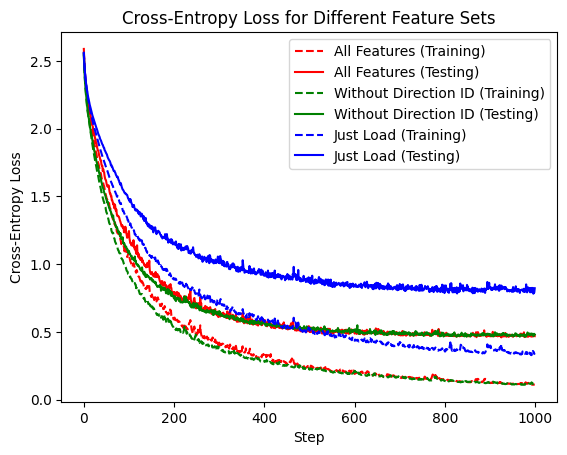

In [ ]:
plt.figure()
plt.plot(range(n_epochs), train_losses_all, 'r--', label='All Features (Training)')
plt.plot(range(n_epochs), test_losses_all, 'r', label='All Features (Testing)')
plt.plot(range(n_epochs), train_losses_wo_dir, 'g--', label='Without Direction ID (Training)')
plt.plot(range(n_epochs), test_losses_wo_dir, 'g', label='Without Direction ID (Testing)')
plt.plot(range(n_epochs), train_losses_load, 'b--', label='Just Load (Training)')
plt.plot(range(n_epochs), test_losses_load, 'b', label='Just Load (Testing)')
plt.xlabel('Step')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss for Different Feature Sets')
plt.legend()
plt.show()

### Accuracy

When plotting the accuracy of these three models, the "without direction_id" model appears to initially rise more quickly than the other two, although the full model catches up quickly and eventually slightly overtakes. The absolute maximum accuracy for both larger models are exactly identical, at 0.8844, while the maximum accuracy for the load-only model is lower at 0.7990. However, even the load-only model has acceptable accuracy for such an unserious application.

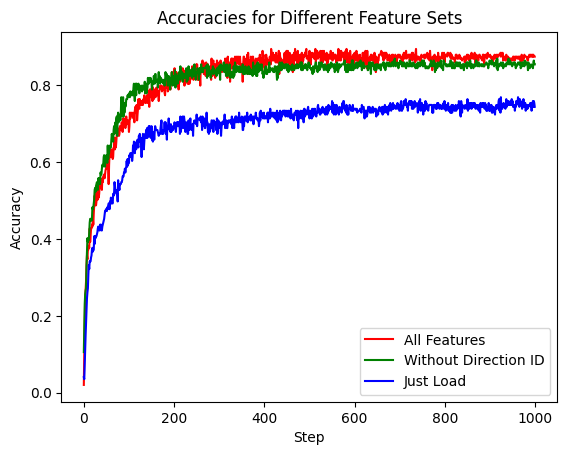

Maximum Accuracy (all features): 0.8944723606109619
Maximum Accuracy (without direction): 0.8693467378616333
Maximum Accuracy (just load): 0.7688442468643188


In [ ]:
plt.figure()
plt.plot(range(n_epochs), accuracies_all, 'r', label='All Features')
plt.plot(range(n_epochs), accuracies_wo_dir, 'g', label='Without Direction ID')
plt.plot(range(n_epochs), accuracies_load, 'b', label='Just Load')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracies for Different Feature Sets')
plt.legend()
plt.show()

print(f"Maximum Accuracy (all features): {max(accuracies_all)}")
print(f"Maximum Accuracy (without direction): {max(accuracies_wo_dir)}")
print(f"Maximum Accuracy (just load): {max(accuracies_load)}")

## Tweaking Hidden Layer Size

### More Nodes

Another knob we can turn to manipulate the predictions of the model is the size of the hidden layer. I did experiment some with the number of hidden layers, but it was tweaking the number of nodes in the single hidden layer that actually made a positive impact on the predictions. In this model, I went a bit overboard and turned the number of nodes in the hidden layer up from 60 to 200.

In [ ]:
# This model includes all inputs with 200 hidden layer nodes
model_hidden = MLP(58, 200, 12).to(device)

optimizer_hidden = optim.SGD(model_hidden.parameters(), lr=learning_rate)
train_losses_hidden = np.zeros((n_epochs,))
test_losses_hidden = np.zeros((n_epochs,))
accuracies_hidden = np.zeros((n_epochs,))


# run model on input set
for epoch in range(n_epochs):
    optimizer_hidden.zero_grad()
    outputs = model_hidden(X_train_all)
    loss = criterion(outputs, y_train_all)
    train_losses_hidden[epoch] = loss.item()

    with torch.no_grad():
        test_outputs_hidden = model_hidden(X_test_all)
        test_loss = criterion(test_outputs_hidden, y_test_all)
        test_losses_hidden[epoch] = test_loss.item()
        accuracies_hidden[epoch] = (torch.sum(test_outputs_hidden.argmax(dim=1) == y_test_all) / y_test_all.shape[0]).tolist()
    loss.backward()
    optimizer_hidden.step()

### Cross-Entropy Loss

As seen in this plot of the cross-entropy loss, the additional nodes cause the loss to drop more abruptly, but still flatten out to about the same minimum loss as the 60-node model by the time 1000 steps has been reached. This is largely true both of the training set loss and the testing set loss.

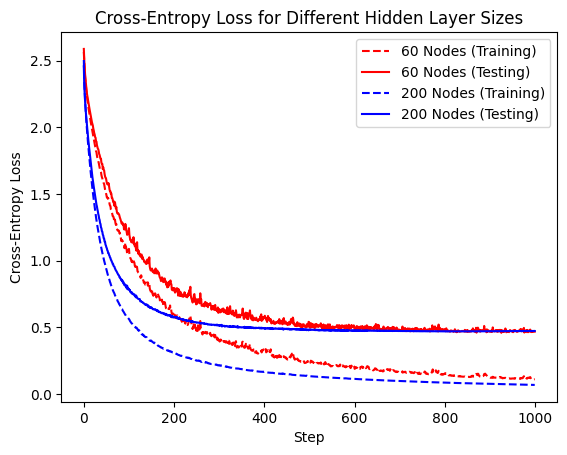

In [ ]:
plt.figure()
plt.plot(range(n_epochs), train_losses_all, 'r--', label='60 Nodes (Training)')
plt.plot(range(n_epochs), test_losses_all, 'r', label='60 Nodes (Testing)')
plt.plot(range(n_epochs), train_losses_hidden, 'b--', label='200 Nodes (Training)')
plt.plot(range(n_epochs), test_losses_hidden, 'b', label='200 Nodes (Testing)')
plt.xlabel('Step')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss for Different Hidden Layer Sizes')
plt.legend()
plt.show()

### Accuracy

The 200-node model causes the accuracy to jump up more quickly, and actually appear to have a local maximum considerably higher than the 60-node model accuracy around 250 steps. However, by 400-1000 steps, the 60-node model accuracy catches up and they both plateau around the same value. In fact, they both have a maximum accuracy throughout the entire model run of 0.889, exactly the same between both models.

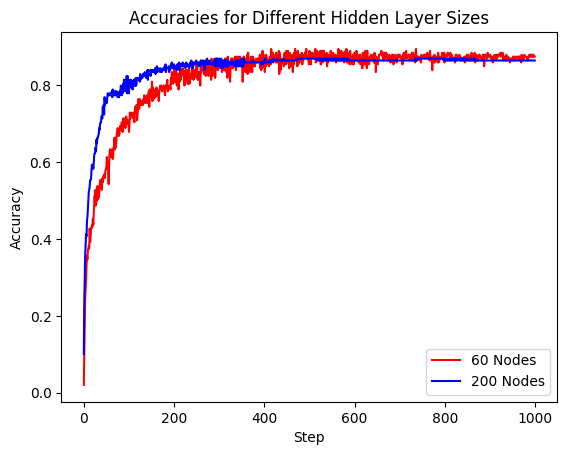

Maximum Accuracy (60 nodes): 0.8944723606109619
Maximum Accuracy (200 nodes): 0.8693467378616333


In [ ]:
plt.figure()
plt.plot(range(n_epochs), accuracies_all, 'r', label='60 Nodes')
plt.plot(range(n_epochs), accuracies_hidden, 'b', label='200 Nodes')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Accuracies for Different Hidden Layer Sizes')
plt.legend()
plt.show()

print(f"Maximum Accuracy (60 nodes): {max(accuracies_all)}")
print(f"Maximum Accuracy (200 nodes): {max(accuracies_hidden)}")

## Overall Performance & Reflection

Here, I have plotted the confusion matrix of the 60-node model with all inputs. There are a few interesting things to note. For instance, the Worcester and Fairmount lines have 100% accuracy, something I would anecdotally attribute to their distinct geography and ridership patterns. The Fairmount line is a short line (read: few stops) that connects to other CR lines at both ends and runs on a high-population corridor, making it likely to stick out and be particularly recognizable in the data. Conversely, the Worcester line is one of, if not the longest line in the network, with the second-largest city in New England on the other end. One can assume this would lead to more end-to-end ridership than many of the other lines, as well as just a larger number of stops on the journey.

### Reflection

Overall, this model ended up doing very well at predicting which MBTA Commuter Rail line a given train was running on, given that train's ridership statistics. I don't think this model could actually be useful for much, but I had a blast making it, and I think it was a wonderful learning experience for making more complex (and more useful) transit-related models going forward.

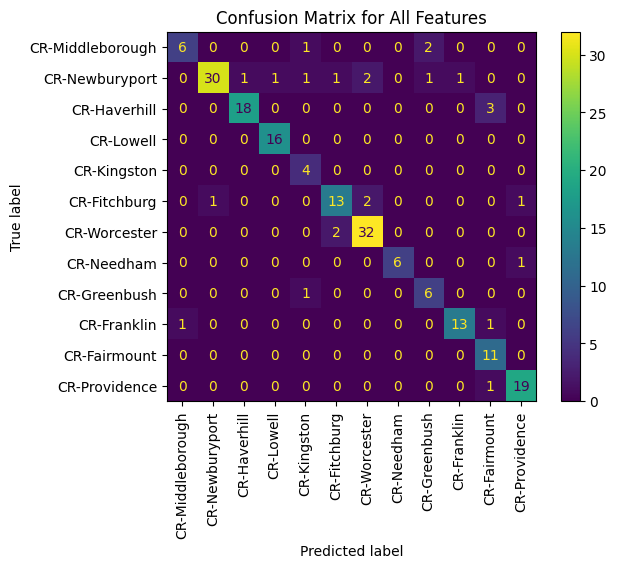

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test_all, test_outputs_all.argmax(dim=1))
disp = ConfusionMatrixDisplay(cm, display_labels=unique)
disp.plot()
plt.xticks(rotation=90)
plt.title('Confusion Matrix for All Features')
plt.show()